# Preprocessing
---

In [2]:
# Imports
import pandas as pd
import numpy as np
import re
from datetime import datetime

In [3]:
# Load Data
data = pd.read_csv('../data/raw/NY_SLI_CLEANED.csv')

/tmp/ipykernel_411513/408629005.py:2: DtypeWarning: Columns (4,8,12,14,15,18) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../data/raw/NY_SLI_CLEANED.csv')


In [4]:
# Explore - List columns
data.columns.tolist()

['Service Line Locality',
 'Street Address',
 'Zip Code',
 'State',
 'Lead Gooseneck, Pigtail or Connector Currently Present',
 'Current Public Side SL Material',
 'Was Public SL Material Ever Previously Lead',
 'Public SL Material Verification Method',
 'Public SL Installation or Replacement Date',
 'Public SL Size',
 'Customer SL Material',
 'Customer SL Material Verification Method',
 'Lead Solder Present',
 'Building Type',
 'POU or POE Treatment Present',
 'Customer SL Installation or Replacement Date',
 'Customer SL Size',
 'SL Category',
 'Note',
 'Location',
 'Customer SL Material Category',
 'Public SL Material Verification Method Category',
 'Current SL Material Category',
 'Lead Connector Present Category',
 'Current Public Side SL Material Category',
 'Was Public SL Material Ever Previously Lead Category',
 'Public SL Installation Year',
 'Public SL Size Category',
 'Public SL Size Numeric',
 'SL Category Cleaned']

In [5]:
# Extract year from mixed date formats
def extract_year(value):
    if pd.isna(value):
        return None
    
    # Convert to string for processing
    value_str = str(value).strip()
    
    # Case 1: Already a 4-digit year
    if value_str.isdigit() and len(value_str) == 4:
        return int(value_str)

    # Case 3: YYYYMMDD format (8 digits)
    if value_str.isdigit() and len(value_str) == 8:
        try:
            year = int(value_str[:4])
            month = int(value_str[4:6])
            day = int(value_str[6:8])
            # Validate it's a reasonable date
            dt = datetime(year, month, day)
            if 1900 <= year <= 2100:
                return year
        except (ValueError, OSError):
            pass  # Not a valid YYYYMMDD, try other formats
    
    # Case 2: Unix timestamp (large integer, positive or negative)
    try:
        num = float(value_str)
        # Unix timestamps are typically 9-10 digits for recent dates
        if abs(num) > 10000000:  # Likely a timestamp
            dt = datetime.fromtimestamp(num)
            return dt.year
    except (ValueError, OSError):
        pass
    
    try:
        # Try parsing with pandas
        dt = pd.to_datetime(value_str, errors='coerce')
        if pd.notna(dt):
            return dt.year
    except:
        pass

    # Dash-separated or slash-separated dates 1999-2000, get first 4 digits
    year_range_match = re.match(r'^(\d{4})-(\d{2,4})$', value_str)
    if year_range_match:
        first_year = int(year_range_match.group(1))
        second_part = year_range_match.group(2)
        
        # If it's abbreviated (e.g., "76" or "77")
        if len(second_part) == 2:
            # Take the first year as the installation year
            return first_year
        else:
            # Full year provided (e.g., "1976-1977")
            return first_year

    
    # Regular Date Formats
    date_formats = [
        "%m/%d/%Y", "%m-%d-%Y", "%Y/%m/%d", "%Y-%m-%d",
        "%d/%m/%Y"
    ]
    for fmt in date_formats:
        try:
            dt = datetime.strptime(value_str, fmt)
            return dt.year
        except ValueError:
            continue
    
    return None  # If nothing works

# Drop empty rows in the date column
# list number of rows
data = data.dropna(subset=['Customer SL Installation or Replacement Date'])

# Drop unknown entries
data = data[~data['Customer SL Installation or Replacement Date'].isin(['Unknown', 'unknown', 'UNK', 'N/A', 'NA', '0'])]

# Filter out negative numbers
data = data[~data['Customer SL Installation or Replacement Date'].astype(str).str.startswith('-')]

# Apply to your dataframe
data['Customer SL Installation or Replacement Date'] = data['Customer SL Installation or Replacement Date'].apply(extract_year)

# Drop rows where year extraction failed
data = data.dropna(subset=['Customer SL Installation or Replacement Date'])
print("Final data shape after year installation fix:", data.shape[0])

# # Save to CSV in data/processed
data.to_csv('../data/processed/NY_SLI_INSTL_YEARS_ADJUSTED.csv', index=False)

Final data shape after year installation fix: 317213


**I saved a subset here that contains the data where we know for sure whether lead is/isnt present**

In [16]:
data_certain = data[data['SL Category Cleaned'] != "Unknown"]


## Experimenting with neighborhoods. 
* cleaned up the town/city name
* dropped cities with less than 50 entries
* plotted frequency
* sorted by frequency and saved to csv

HICKSVILLE: 12308
Elmira: 9140
HUNTINGTON STATION: 8155
Clay: 8024
NEW CITY: 6777
MELVILLE: 5543
Scarsdale: 5513
Cortland: 4743
Wappingers: 4175
FISHKILL: 3920
PEARL RIVER: 3894
Cicero: 3825
NANUET: 3765
Newburgh: 3378
ENDWELL: 3365
Manlius: 3320
Ballston: 3259
Ontario: 3244
Onondaga: 2953
Salina: 2917
Ithaca: 2680
Gansevoort: 2565
Glens Falls: 2550
Waterford: 2447
SPRING VALLEY: 2383
MONSEY: 2241
Lysander: 2178
CONGERS: 2120
Southport: 2049
Smithtown: 2040
Spring Valley: 2035
HIGHLAND MILLS: 2016
AIRMONT: 2014
DELMAR: 1992
VALLEY COTTAGE: 1955
Beacon: 1906
CHESTNUT RIDGE: 1892
Lansing: 1888
HUNTINGTON: 1830
Erwin: 1724
Camillus: 1724
NEW ROCHELLE: 1653
STONY POINT: 1635
TAPPAN: 1623
Saint James: 1608
RAMAPO: 1590
GLENMONT: 1539
HAVERSTRAW-THLLS: 1502
Big Flats: 1448
Kings Park: 1445
ORANGEBURG: 1283
WEST NYACK: 1267
WESTBURY: 1262
Geddes: 1214
ENDICOTT: 1182
Village of Elmira Heights: 1155
Saratoga Springs: 1088
Horseheads: 1077
SELKIRK: 1071
ALBERTSON: 1058
SLINGERLANDS: 1037
GENEVA:

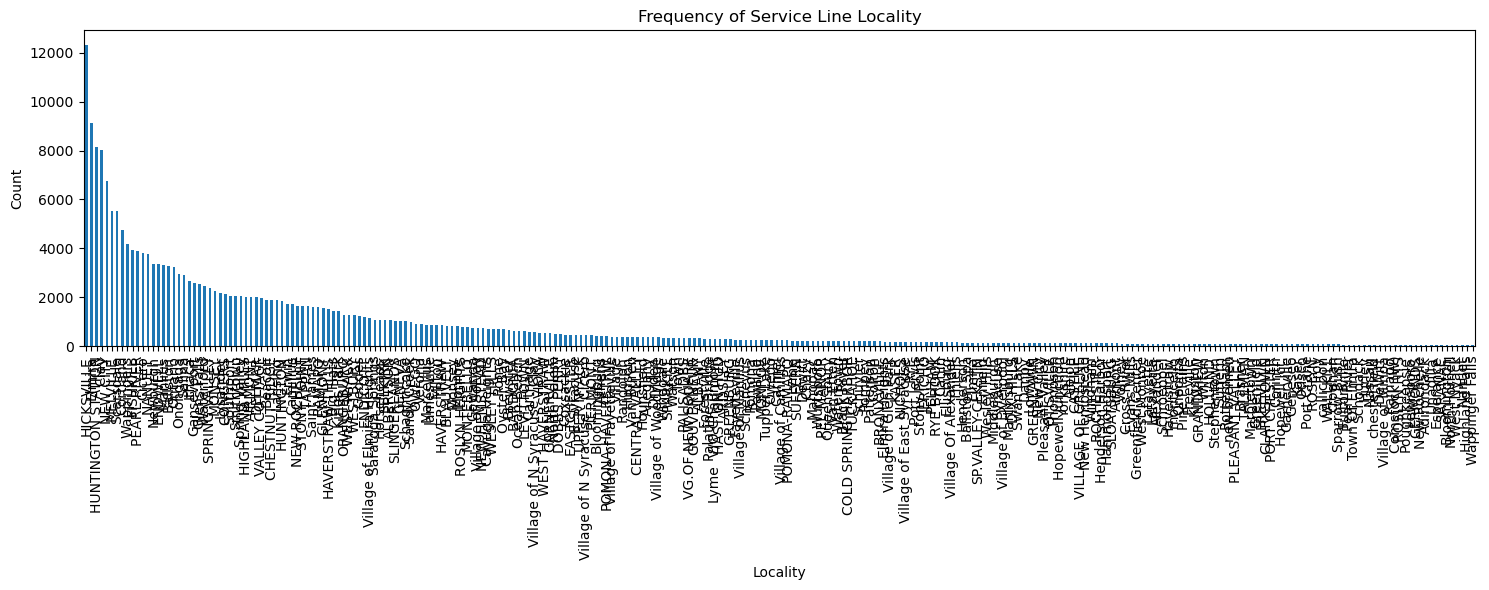

,Service Line Locality,Street Address,Zip Code,State,"Lead Gooseneck, Pigtail or Connector Currently Present",Current Public Side SL Material,Was Public SL Material Ever Previously Lead,Public SL Material Verification Method,Public SL Installation or Replacement Date,Public SL Size,...,Customer SL Material Category,Public SL Material Verification Method Category,Current SL Material Category,Lead Connector Present Category,Current Public Side SL Material Category,Was Public SL Material Ever Previously Lead Category,Public SL Installation Year,Public SL Size Category,Public SL Size Numeric,SL Category Cleaned
0,HICKSVILLE,145 9TH ST,11801,NY,No,Copper,No,Records,10/3/1950,"Upto 1""",...,Copper,Records,Copper,no,Copper,no,NaN,NaN,1.0,Non-Lead
1,HICKSVILLE,38 WILLET AVE,11801,NY,No,Copper,No,Records,9/7/1953,"Upto 1""",...,Copper,Records,Copper,no,Copper,no,NaN,NaN,1.0,Non-Lead
2,HICKSVILLE,163 WOODBURY RD,11801,NY,Yes,Galvanized,No,Records,7/17/1930,"Upto 1""",...,Copper,Records,Galvanized,yes,Galvanized,no,NaN,NaN,1.0,Non-Lead
3,HICKSVILLE,37 ALLING ST,11801,NY,No,Copper,No,Records,6/26/1958,"Upto 1""",...,Copper,Records,Copper,no,Copper,no,NaN,NaN,1.0,Non-Lead
4,HICKSVILLE,53 ANGLE LN,11801,NY,No,Copper,No,Records,6/8/1950,"Upto 1""",...,Copper,Records,Copper,no,Copper,no,NaN,NaN,1.0,Non-Lead
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226474,Wappinger Falls,14 Doe Trail,12590,NY,No,Known Other,No,Statistical Analysis/Predictive Model,2010,"Upto 1""",...,Other,Predictive Model,Other,no,Other,no,1970.0,NaN,1.0,Non-Lead
226475,Wappinger Falls,55 Berry Ln,12590,NY,No,Known Other,No,Statistical Analysis/Predictive Model,2014,"Upto 1""",...,Other,Predictive Model,Other,no,Other,no,1970.0,NaN,1.0,Non-Lead
226476,Wappinger Falls,8 Berry Ln,12590,NY,No,Known Other,No,Statistical Analysis/Predictive Model,2014,"Upto 1""",...,Other,Predictive Model,Other,no,Other,no,1970.0,NaN,1.0,Non-Lead
226477,Wappinger Falls,33 Berry Ln,12590,NY,No,Known Other,No,Statistical Analysis/Predictive Model,2014,"Upto 1""",...,Other,Predictive Model,Other,no,Other,no,1970.0,NaN,1.0,Non-Lead


In [8]:
# Replace "Town of X" or "T of X" or "City of X" with just "X" in 'Service Line Locality'
data_certain.loc[:, 'Service Line Locality'] = data_certain['Service Line Locality'].str.replace(r'^(Town of |T of |City of |VG |V of )', '', regex=True).str.strip()

locality_counts = data_certain[data_certain['SL Category Cleaned'] == 'Lead']['Service Line Locality'].value_counts()

locality_counts = data_certain['Service Line Locality'].value_counts()


n = 50  # threshold to drop
localities_to_keep = locality_counts[locality_counts >= n].index
data_certain = data_certain[data_certain['Service Line Locality'].isin(localities_to_keep)]
locality_counts = data_certain['Service Line Locality'].value_counts()



for locality, count in locality_counts.items():
    print(f"{locality}: {count}")

import matplotlib.pyplot as plt

# Plot the frequency diagram (bar chart)
plt.figure(figsize=(15, 6))
locality_counts.plot(kind='bar')
plt.xlabel('Locality')
plt.ylabel('Count')
plt.title('Frequency of Service Line Locality')
plt.tight_layout()
plt.show()

# Reorder data_certain so that rows are sorted by the frequency of their 'Service Line Locality'
data_certain = data_certain.set_index('Service Line Locality').loc[locality_counts.index].reset_index()

data_certain.to_csv('../data/processed/NY_SLI_YEARS_ADJUSTED_NO_UNKNOWNS.csv', index=False)


data_certain


In [ ]:
elmira = data_certain[data_certain['Service Line Locality'] == 'Elmira']



316

In [ ]:
df = data_certain


def get_sample_split(df, n_samples=20):
    df = df[df['Service Line Locality'] != 'Pelham Manor'] #only lead here lol

    lead_df = df[df['SL Category Cleaned'] == 'Lead']
    nonlead_df = df[df['SL Category Cleaned'] != 'Lead']

    lead_locality_counts = lead_df['Service Line Locality'].value_counts()
    nonlead_locality_counts = nonlead_df['Service Line Locality'].value_counts()

    lead_df = lead_df.set_index('Service Line Locality').loc[lead_locality_counts.index].reset_index()
    nonlead_df = nonlead_df.set_index('Service Line Locality').loc[nonlead_locality_counts.index].reset_index()

    print(lead_locality_counts)
    print(nonlead_locality_counts)

    lead_sample = (
        lead_df.groupby('Service Line Locality')
        .apply(lambda x:  x.sample(n = n_samples) if (x.shape[0]>n_samples - 1) else x)
        .reset_index(drop=True)
        .set_index('Service Line Locality')
        .loc[lead_locality_counts.index]
        .reset_index()
    )
    nonlead_sample = (
        nonlead_df.groupby('Service Line Locality')
        .apply(lambda x:  x.sample(n = n_samples) if (x.shape[0]>n_samples - 1) else x)
        .reset_index(drop=True)
        .set_index('Service Line Locality')
        .loc[lead_locality_counts.index]
        .reset_index()
    )
    nonlead_sample = nonlead_sample[:len(lead_sample)]
    return lead_sample, nonlead_sample

a, b = get_sample_split(df)


def interleave(a, b):
    concat_df = pd.concat([df1,df2]).sort_index().set_index('index')
    return concat_df


interleave(a, b)[0:50]

Service Line Locality
City of Elmira          314
Village of Solvay       205
NEW ROCHELLE            160
ROCHESTER                77
Scarsdale                76
                       ... 
Village of Marcellus      1
Warsaw                    1
CHESTNUT RIDGE            1
MN                        1
Eastchester               1
Name: count, Length: 74, dtype: int64
Service Line Locality
HICKSVILLE            12307
HUNTINGTON STATION     8155
Town of Clay           8024
City of Elmira         7059
NEW CITY               6776
                      ...  
Nunda                     1
ALBERTASON                1
VG NEW SQUARE             1
Haverstraw-thlls          1
Delevan                   1
Name: count, Length: 618, dtype: int64


,Service Line Locality,Street Address,Zip Code,State,"Lead Gooseneck, Pigtail or Connector Currently Present",Current Public Side SL Material,Was Public SL Material Ever Previously Lead,Public SL Material Verification Method,Public SL Installation or Replacement Date,Public SL Size,...,Customer SL Material Category,Public SL Material Verification Method Category,Current SL Material Category,Lead Connector Present Category,Current Public Side SL Material Category,Was Public SL Material Ever Previously Lead Category,Public SL Installation Year,Public SL Size Category,Public SL Size Numeric,SL Category Cleaned
0,City of Elmira,151 WASHINGTON AVE. (EAST),14901,NY,NaN,Lead including lead-lined galvanized,Unknown,Records,1922,"Upto 1""",...,Copper,Records,Lead,unknown,Lead,no,1970.0,NaN,1.0,Lead
1,City of Elmira,956 ERIE ST.,14904,NY,NaN,Copper,Unknown,Records,1973,"Upto 1""",...,Copper,Records,Copper,unknown,Copper,no,1970.0,NaN,1.0,Non-Lead
2,City of Elmira,34 GOULD ST.,14905,NY,NaN,Copper,Unknown,Records,1997,"Upto 1""",...,Copper,Records,Copper,unknown,Copper,no,1970.0,NaN,1.0,Non-Lead
3,City of Elmira,307-309 RAILROAD AVE,14901,NY,NaN,Lead including lead-lined galvanized,Unknown,Records,Unknown,"Upto 1""",...,Lead,Records,Lead,unknown,Lead,no,NaN,NaN,1.0,Lead
4,City of Elmira,302 MARKET ST. (EAST),14901,NY,NaN,Lead including lead-lined galvanized,Unknown,Records,1919,"Upto 1""",...,Lead,Records,Lead,unknown,Lead,no,1970.0,NaN,1.0,Lead
5,City of Elmira,524 ESTY ST.,14904,NY,NaN,Copper,Unknown,Records,1933,"Upto 1""",...,Copper,Records,Copper,unknown,Copper,no,1970.0,NaN,1.0,Non-Lead
6,City of Elmira,116 MILLER ST. (WEST),14904,NY,NaN,Lead including lead-lined galvanized,Unknown,Records,1918,"Upto 1""",...,Galvanized,Records,Lead,unknown,Lead,no,1970.0,NaN,1.0,Lead
7,City of Elmira,100 FERRIS ST.,14904,NY,NaN,Known Other,No,Records,1983,"larger than 2""",...,Other,Records,Other,unknown,Other,no,1970.0,NaN,2.0,Non-Lead
8,City of Elmira,856 LAKE ST.,14901,NY,NaN,Lead including lead-lined galvanized,Unknown,Records,Unknown,"Upto 1""",...,Copper,Records,Lead,unknown,Lead,no,NaN,NaN,1.0,Lead
9,City of Elmira,320 DIVEN AVE,14901,NY,NaN,Copper,Unknown,Records,1956,"Upto 1""",...,Copper,Records,Copper,unknown,Copper,no,1970.0,NaN,1.0,Non-Lead
